Dataset Shape: (35040, 10)
Columns: ['turbine_id', 'rotor_speed_rpm', 'wind_speed_mps', 'power_output_kw', 'gearbox_oil_temp_c', 'generator_bearing_temp_c', 'vibration_level_mmps', 'ambient_temp_c', 'humidity_pct', 'maintenance_label']


,turbine_id,rotor_speed_rpm,wind_speed_mps,power_output_kw,gearbox_oil_temp_c,generator_bearing_temp_c,vibration_level_mmps,ambient_temp_c,humidity_pct,maintenance_label
0,1,15.496714,7.861736,1564.768854,72.615149,73.829233,1.953173,17.896064,67.674347,0
1,1,15.079832,7.840483,1502.222183,62.861035,72.340913,1.976505,11.110395,52.320235,0
2,1,17.559488,8.394233,1512.221917,62.422822,71.998731,2.189488,11.455170,53.644403,0
3,1,15.822545,6.779156,1520.886360,55.201649,68.359070,2.039372,13.692333,61.713683,0
4,1,15.564464,8.025501,1547.319325,68.295953,86.703732,2.214197,10.482082,64.191021,1


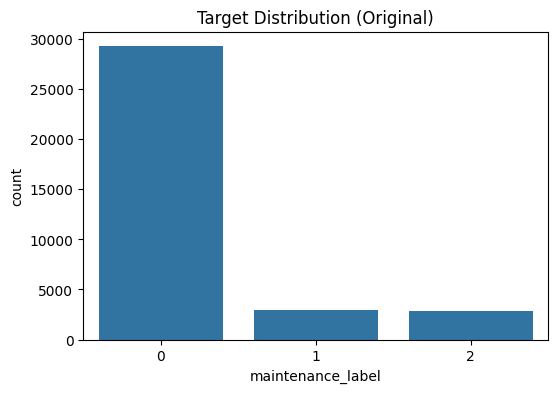

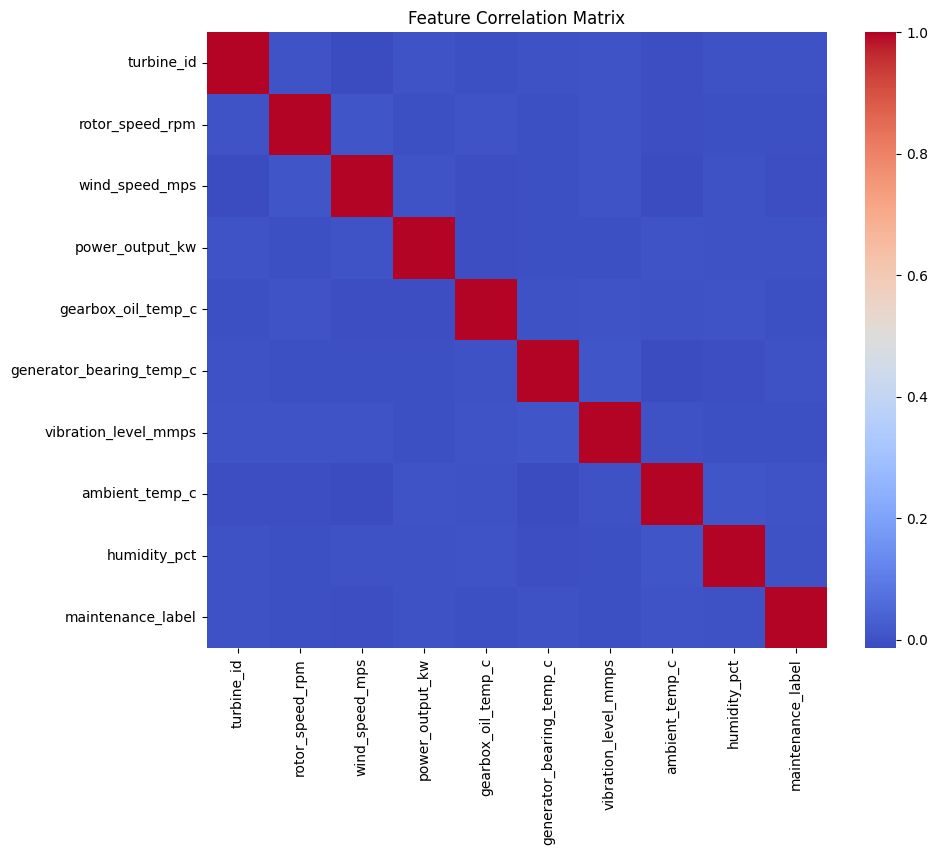

Original Target Values: [0 1 2]
New Binary Target Values: [0 1]
Data split successfully!
Logistic Regression AUC: 0.505
Decision Tree (max_depth=5) AUC: 0.501
XGBoost AUC: 0.487
Model and Vectorizer saved to 'model.bin'


In [2]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb
import pickle
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Cell 2: Data Loading & Preparation
# Load data
df = pd.read_csv('data.csv')

# Clean column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Handle missing values (simple strategy for baseline)
df = df.fillna(0)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# Cell 3: Exploratory Data Analysis (EDA)
# Check target distribution
plt.figure(figsize=(6, 4))
# Assuming target is 'maintenance_label'. If your column name is different, change it here.
sns.countplot(x=df['maintenance_label']) 
plt.title('Target Distribution (Original)')
plt.show()

# Check correlations for numerical features
plt.figure(figsize=(10, 8))
numerical_cols = df.select_dtypes(include=['number']).columns
sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Cell 4: Validation Framework (FIXED)
# 1. Inspect the original unique values
print("Original Target Values:", df['maintenance_label'].unique())

# 2. CONVERT TO BINARY:
# If label > 0 (i.e., 1 or 2), it becomes 1 (Needs Maintenance).
# If label == 0, it stays 0 (Healthy).
df['maintenance_label'] = (df['maintenance_label'] > 0).astype(int)

print("New Binary Target Values:", df['maintenance_label'].unique())

# 3. Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.maintenance_label.values
y_val = df_val.maintenance_label.values
y_test = df_test.maintenance_label.values

del df_train['maintenance_label']
del df_val['maintenance_label']
del df_test['maintenance_label']

print("Data split successfully!")

# Cell 5: Feature Engineering
# Identify categorical and numerical columns
categorical = list(df_train.select_dtypes(include=['object']).columns)
numerical = list(df_train.select_dtypes(include=['number']).columns)

dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Cell 6: Model 1 - Logistic Regression (Baseline)
# Solver 'liblinear' works well for binary classification
lr = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict_proba(X_val)[:, 1] # Probability of class 1
print(f"Logistic Regression AUC: {roc_auc_score(y_val, y_pred_lr):.3f}")

# Cell 7: Model 2 - Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict_proba(X_val)[:, 1]
print(f"Decision Tree (max_depth=5) AUC: {roc_auc_score(y_val, y_pred_dt):.3f}")

# Cell 8: Model 3 - XGBoost
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred_xgb = model.predict(dval)
print(f"XGBoost AUC: {roc_auc_score(y_val, y_pred_xgb):.3f}")

# Cell 9: Select Best Model & Save
# We assume XGBoost or Random Forest is usually best.
# Here we save the XGBoost model and the DictVectorizer.
with open('model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

print("Model and Vectorizer saved to 'model.bin'")